In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
import warnings
import fiona
import rasterio
import regionmask
warnings.filterwarnings('ignore')

import geopandas as gpd


# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = 'https://raw.githubusercontent.com/orianac/futuredrought/develop/pangeo-zarr-cmip6.json'
# col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
pd.set_option('display.max_rows', 250) # so that we can see all of the different experiments available

In [3]:
 # Different variable options : 
#'mrro' - runoff
#'snw' - SWE
 #hfls - latent heat
 # mrros - surface runoff
 # mrso - soil moisture
 # pr - precipitation
 # tas - mean daily air temperature
 # prra - rainfall rate
 # prsn - snowfall rate

variable_of_interest = 'mrro'

# load your dataset at the timestep you want (monthly or daily)

In [4]:

analysis_timestep = 'Lmon' # or 'day'
cat = col.search(experiment_id=['historical', 
                                'ssp585', 
                               'ssp370',
                                'ssp126', 
                                'ssp245',],#, 'ssp126', 'ssp245', 'ssp370'],
                 table_id=analysis_timestep,             
                 variable_id=variable_of_interest) 
# this is a hack just to get around the different grid_label strings
cat.df['grid_label']='gn'

In [5]:
future_slice = slice('2070','2099')
historical_slice = slice('1985','2014')
slices = {'historical': slice('1985','2014'),
          'ssp585': slice('2070','2099')}
slices_ranges = {'historical': pd.date_range('1985-01-01', '2014-12-31', freq='M'),
                 'ssp585': pd.date_range('2070-01-01', '2099-12-31', freq='M')}

In [6]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
    try:
# rename spatial dimensions if necessary
        if ('longitude' in ds.dims) and ('latitude' in ds.dims):
            ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    #     ds = ds.sel(time=time_slice) # subset the data for the time period of interest

        # drop redundant variables (like "height: 2m")
        for coord in ds.coords:
            if coord not in ['lat','lon','time']:
                ds = ds.drop(coord)

        # Add dataset to dictionary, selecting first member_id for each simulation since we'll just use
        # one ensemble member right now
        ds_dict[name] = ds.isel(member_id=0)
    except:
        print(name)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 150 group(s)


ScenarioMIP.CCCma.CanESM5.ssp126.Lmon.gn
ScenarioMIP.CCCma.CanESM5.ssp585.Lmon.gn
ScenarioMIP.CCCma.CanESM5.ssp370.Lmon.gn
CMIP.CCCma.CanESM5.historical.Lmon.gn



In [7]:
def calculate_change(historic, future, percentage=True):
    if percentage:
        return (future - historic)/(historic) * 100
    else:
        return future - historic

In [8]:
def annual_mean(ts):
    return ts.mean(dim='time')

In [9]:
def stdev(ts, timestep, freq='monthly'):
    if timestep == 'Lmon':
        return ts.std(dim='time')
    elif timestep == 'day':
        if freq == 'monthly':
            return ts.resample(time='M').mean().std(dim='time')
        else:
            print('calculating daily')
            return ts.std(dim='time')

In [10]:
def low_runoff(ts):
    return ts.resample(time='M').mean().groupby('time.year').min().min(dim='year')

In [11]:
def add_cartopy_elements(ax):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='black')
    ax.add_feature(cartopy.feature.OCEAN, color='grey')
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

In [12]:
def plot_nicely(ax, ds, vmin, vmax, cmap='viridis', cbar_label=None, title=None):

    # plot.contourf(ax=ax, levels=n.arange(min_var, max_var, interval))
    ds.plot(ax=ax, transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax, cmap=cmap, 
            levels=11,
           cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    add_cartopy_elements(ax)



# load and regrid to a common grid

In [13]:
def calculate_qflow(da, rolling_period=30, minimum=True):
    '''calculate n-day (based upon rolling_period) moving average.
    if minimum, returns the minimum value in the 30 year period
    if not, returns the average'''
    if minimum:
        return da.rolling(time=rolling_period, 
                          center=True).mean().groupby('time.year').min().min(dim='year')
    else:
        return da.rolling(time=rolling_period, 
                          center=True).mean().groupby('time.year').min().mean(dim='year')

In [14]:
def variability(da):
    return da.resample(time='M').mean().std(dim='time')

In [15]:
def bias(sim, obs, method):
    if method=='percent':
        return (sim-obs)/obs*100
    elif method=='absolute':
        return sim - obs

# Read in the countries shapefile and make masks

In [16]:
def monthly_intraannual_range(da, timestep):
    ''' 
    calculate yearly range based upon monthly runoff
    '''
    if timestep == 'Lmon':
        return da.groupby('time.year').max(dim='time') - \
            da.groupby('time.year').min(dim='time')
    elif timestep == 'day':
        return da.resample(time='M').mean().groupby('time.year').max(dim='time') - \
            da.resample(time='M').mean().groupby('time.year').min(dim='time')

In [17]:
def lowest_10thpercentile(da, timestep):
    if timestep == 'Lmon':
        return da.groupby('time.year').min(dim='time').compute().quantile(0.1, dim='year')
    elif timestep == 'day':
        return da.resample(time='M').mean().groupby('time.year').min(dim='time').compute().quantile(0.1, dim='year')

In [18]:
def basin_average_intraannual_range(monthly_ds, 
                                   multiple_ensemble_members=False,
                                  return_ensemble=False):
    basin_mean = monthly_ds.mean(dim= ['latitude', 'longitude'])
    hydrologic_range = monthly_intraannual_range(basin_mean, 'Lmon').mean(dim='year')
                    # present the range normalized by total runoff
    basin_mean_range = hydrologic_range*30/(basin_mean.mean(dim='time')*365)
    if multiple_ensemble_members:
        if return_ensemble:
            return basin_mean_range
        else:
            return float(basin_mean_range.mean(dim='gcm'))
    else:
        return float(basin_mean_range.values)
    

In [19]:
def map_gridded_to_basins(da, masks, geographic_gdf_in, 
                          comparison_da=None, masks2=None, num_cells_threshold=1):
    '''Input: gridded xarray data array on lat/lon coordinates
    we assume that the da is the obs dataset and comparison_da is the sim,
    so any comparisons are w.r.t. the da'''
    da = da.rename({'lon': 'longitude',
                       'lat': 'latitude'})
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) 
                                         - 180)).sortby('longitude')
    geographic_gdf = geographic_gdf_in.copy(deep=True)
    geographic_gdf['mean'] = np.nan
    geographic_gdf['h_range'] = np.nan
    geographic_gdf['NumCells'] = np.nan
    lat = masks.latitude.values
    lon = masks.longitude.values
    if comparison_da is not None:
        comparison_da = comparison_da.rename({'lon': 'longitude',
                       'lat': 'latitude'})
        comparison_da = comparison_da.assign_coords(longitude=(((comparison_da.longitude + 180) % 360) 
                                         - 180)).sortby('longitude')
    for ID_REGION in tqdm(geographic_gdf.index.values):
        sel_mask = masks.where(masks == ID_REGION).values
        num_cells = (~np.isnan(sel_mask)).sum()
        geographic_gdf.at[ID_REGION, 'NumCells'] = num_cells
        
        if num_cells < num_cells_threshold:
#             print('{} has zero cells!'.format(ID_REGION))
            continue
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        trimmed_mask = masks.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                        longitude = slice(id_lon[0], id_lon[-1]))

        out_sel = da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                        longitude = slice(id_lon[0], id_lon[-1])
                       ).compute()
        out_sel = out_sel.where(trimmed_mask == ID_REGION)
        if comparison_da is None:
            mean_to_fill = float(out_sel.mean().values)
            hr_to_fill = basin_average_intraannual_range(out_sel)
        else:
            comparison_da_sel = comparison_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                        longitude = slice(id_lon[0], id_lon[-1])
                       ).compute().where(masks == ID_REGION)
            # comparison_da is the simulated 
            if metric=='mean':
                value_to_fill = (comparison_da_sel - out_sel).mean(
                                    dim=['latitude', 'longitude'])/out_sel.mean(dim=['latitude', 'longitude'])*100
            elif metric=='std':
                value_to_fill = (comparison_da_sel - out_sel).mean(
                                    dim=['latitude', 'longitude'])/out_sel.mean(dim=['latitude', 'longitude'])*100
            elif metric=='hydrologic_range':
                base_case = basin_average_intraannual_range(out_sel).mrro.values
                comparison_case = basin_average_intraannual_range(comparison_da_sel,
                                                                 multiple_ensemble_members=True).mrro.values
                value_to_fill = comparison_case - base_case
        geographic_gdf.at[ID_REGION, 'mean'] = mean_to_fill
        geographic_gdf.at[ID_REGION, 'h_range'] = hr_to_fill
    return geographic_gdf

# Read in the basin and country shapefile and make masks

In [21]:
def rasterize_shapefile(shapefile, sample_grid_file, name):
    '''
    Inputs:
    shapefile: shapefile of the regions you want to rasterize
    sample_grid_file: xarray datarray with the grid you want to rasterize the shapefile to
    name: the name of the column in the shapefile that has the labels for the polygons
    '''
    sample_grid_file = sample_grid_file.rename({'lon': 'longitude',
                   'lat': 'latitude'})
    sample_grid_file = sample_grid_file.assign_coords(longitude=(((sample_grid_file.longitude + 180) % 360) 
                                     - 180)).sortby('longitude')
    mask_poly = regionmask.Regions_cls(name='mask', 
                                        numbers=list(range(0,len(shapefile)-1)), 
                                        names=list(shapefile[name]), 
                                        abbrevs=list(shapefile[name]), 
                                        outlines=list(shapefile.geometry.values[i] 
                                                      for i in range(0,len(shapefile)-1)))
    mask = mask_poly.mask(sample_grid_file, lat_name='latitude', 
                            lon_name='longitude',
                            wrap_lon=False)
    return mask, mask_poly

# combine basin shapefile and country shapefile to find every overlap and we'll call that SUBBASIN

In [22]:
recreate_shapefile = False
if recreate_shapefile:
    basins = gpd.read_file('shapefile_test/Major_Basins_of_the_World.dbf')
    # Remove the basins that don't have geometries attached to them
    basins = basins[basins.geometry!=None]

    countries = gpd.read_file('Countries_WGS84.dbf')
    subbasins = gpd.overlay(basins, countries, how='union')
    # make a new column which has a combined ID
    subbasins['SUBBASIN_N'] = subbasins['NAME']+'_'+subbasins['CNTRY_NAME']
    subbasins = subbasins[~subbasins['SUBBASIN_N'].isna()]
    subbasins.to_file('country_basin_join.shp')
else:
    basins = gpd.read_file('shapefile_test/Major_Basins_of_the_World.dbf')
    basins = basins[basins.geometry!=None]
    subbasins = gpd.read_file('country_basin_join.shp')

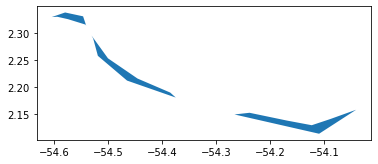

# Calculate grid means for each different GCM simulation

In [22]:
# pick out the GCMs that have a corresponding historical setup
setup_list = list(dset_dict.keys())
valid_setups = {}
for setup in ['ssp585', 'ssp370', 'ssp126', 'ssp245']:
    valid_setups[setup] = []
    for gcm_run in setup_list:
        if setup in gcm_run:
            gcm_label = '.'.join(gcm_run.split('.')[1:3])
            if 'CMIP.{}.historical.Lmon.gn'.format(gcm_label) in setup_list:
                valid_setups[setup].append(gcm_label)

In [33]:
for gcm in valid_setups['ssp585']:
    for setup in ['ssp585', 'ssp370', 'ssp126', 'ssp245']:
        if gcm in valid_setups[setup]:
            continue
        else:
            print('{} not present in setup {}'.format(gcm, setup))
    

NOAA-GFDL.GFDL-CM4 not present in setup ssp370
NOAA-GFDL.GFDL-CM4 not present in setup ssp126
FIO-QLNM.FIO-ESM-2-0 not present in setup ssp370


# calculate all of the basin changes separated out by changes per country in the basin

In [28]:
subbasins_to_test = subbasins[subbasins['SUBBASIN_N']=='Amazon_French Guiana']#.plot()
gcm_label='NCAR.CESM2'
historical_setup = 'CMIP.{}.historical.Lmon.gn'.format(gcm_label)
sample_file = ds_dict[historical_setup].isel(time=0).compute()

raster_subbasins, subbasin_poly_mask = rasterize_shapefile(subbasins_to_test, 
                                                                   sample_file, 
                                                                   'SUBBASIN_N')

All elements of mask are NaN. Try to set 'wrap_lon=True'.


In [23]:
subbasins_changes = {}

In [55]:
# calculate basin averages for each of the 20 GCMs
recalculate_basin_means=True
recalculate_historical=True
recalculate_future=True
if recalculate_basin_means:
    for gcm_label in valid_setups['ssp585']: 
        print(gcm_label)
        if gcm_label in ['CSIRO-ARCCSS.ACCESS-CM2',
             'MIROC.MIROC-ES2L',
             'CCCma.CanESM5-CanOE',
             'INM.INM-CM5-0',
              'CAMS.CAMS-CSM1-0',
              'EC-Earth-Consortium.EC-Earth3-Veg',
              'INM.INM-CM4-8',
              'CSIRO-ARCCSS.ACCESS-CM2',
              'CCCma.CanESM5',
             'UA.MCM-UA-1-0',
             'NIMS-KMA.KACE-1-0-G',
             'NOAA-GFDL.GFDL-CM4',
             'CSIRO.ACCESS-ESM1-5',
             'NCAR.CESM2',
             'MRI.MRI-ESM2-0',
         'FIO-QLNM.FIO-ESM-2-0',
         'MIROC.MIROC6',
         'MPI-M.MPI-ESM1-2-LR']:
            print('{} already done!'.format(gcm_label))
            continue
        
        historical_setup = 'CMIP.{}.historical.Lmon.gn'.format(gcm_label)

        
        # first make the raster-to-polygon mapping for this grid
        sample_file = ds_dict[historical_setup].isel(time=0).compute()
        raster_subbasins, subbasin_poly_mask = rasterize_shapefile(subbasins, 
                                                                   sample_file, 
                                                                   'SUBBASIN_N')

        print("Woohoo! You've finished rasterizing your shapefile for {}".format(gcm_label))
        if recalculate_historical:
            subbasins_historical = map_gridded_to_basins(ds_dict[historical_setup].mrro, 
                                               raster_subbasins, subbasins)
            subbasins_historical.to_file('{}_polygon_historical.shp'.format(gcm_label))
            print("Excellent! You've finished the historical shapefile for {}".format(gcm_label))

        # rasterize the subbasin differently for every 
        if recalculate_future:
            subbasins_future, subbasins_changes = {}, {}
            for setup in ['ssp585']: # eventually do it for all setups
                print(setup, gcm)
                future_setup = 'ScenarioMIP.{}.{}.Lmon.gn'.format(gcm_label, setup)
                subbasins_future[setup] = map_gridded_to_basins(ds_dict[future_setup].mrro, 
                                               raster_subbasins, subbasins)


                subbasins_future[setup].to_file('{}_{}_polygon_future.shp'.format(gcm_label, setup))

                subbasins_changes[setup] = subbasins.copy(deep=True)
                for metric in ['mean', 'h_range']:
                    subbasins_changes[setup][metric] = (subbasins_future[setup][metric] - 
                                                        subbasins_historical[metric])/subbasins_historical[metric]
                subbasins_changes[setup].to_file('{}_{}_polygon_changes.shp'.format(gcm_label, setup))
else:
    subbasins_with_mean_changes = gpd.read_file('MIROC6_polygon_changes.shp')

BCC.BCC-CSM2-MR
Woohoo! You've finished rasterizing your shapefile for BCC.BCC-CSM2-MR



Excellent! You've finished the historical shapefile for BCC.BCC-CSM2-MR
ssp585 CCCma.CanESM5



CAMS.CAMS-CSM1-0
CAMS.CAMS-CSM1-0 already done!
CSIRO-ARCCSS.ACCESS-CM2
CSIRO-ARCCSS.ACCESS-CM2 already done!
EC-Earth-Consortium.EC-Earth3-Veg
EC-Earth-Consortium.EC-Earth3-Veg already done!
MIROC.MIROC-ES2L
MIROC.MIROC-ES2L already done!
INM.INM-CM4-8
INM.INM-CM4-8 already done!
INM.INM-CM5-0
INM.INM-CM5-0 already done!
MRI.MRI-ESM2-0
MRI.MRI-ESM2-0 already done!
NIMS-KMA.KACE-1-0-G
NIMS-KMA.KACE-1-0-G already done!
NOAA-GFDL.GFDL-CM4
NOAA-GFDL.GFDL-CM4 already done!
UA.MCM-UA-1-0
UA.MCM-UA-1-0 already done!
NCAR.CESM2
NCAR.CESM2 already done!
CSIRO.ACCESS-ESM1-5
CSIRO.ACCESS-ESM1-5 already done!
CCCma.CanESM5-CanOE
CCCma.CanESM5-CanOE already done!
MIROC.MIROC6
MIROC.MIROC6 already done!
FIO-QLNM.FIO-ESM-2-0
FIO-QLNM.FIO-ESM-2-0 already done!
MPI-M.MPI-ESM1-2-LR
MPI-M.MPI-ESM1-2-LR already done!
CNRM-CERFACS.CNRM-ESM2-1
Woohoo! You've finished rasterizing your shapefile for CNRM-CERFACS.CNRM-ESM2-1



Excellent! You've finished the historical shapefile for CNRM-CERFACS.CNRM-ESM2-1
ssp585 CCCma.CanESM5



MOHC.UKESM1-0-LL
Woohoo! You've finished rasterizing your shapefile for MOHC.UKESM1-0-LL



Excellent! You've finished the historical shapefile for MOHC.UKESM1-0-LL
ssp585 CCCma.CanESM5



NCAR.CESM2-WACCM
Woohoo! You've finished rasterizing your shapefile for NCAR.CESM2-WACCM



Excellent! You've finished the historical shapefile for NCAR.CESM2-WACCM
ssp585 CCCma.CanESM5



CNRM-CERFACS.CNRM-CM6-1
Woohoo! You've finished rasterizing your shapefile for CNRM-CERFACS.CNRM-CM6-1



Excellent! You've finished the historical shapefile for CNRM-CERFACS.CNRM-CM6-1
ssp585 CCCma.CanESM5



IPSL.IPSL-CM6A-LR
Woohoo! You've finished rasterizing your shapefile for IPSL.IPSL-CM6A-LR



Excellent! You've finished the historical shapefile for IPSL.IPSL-CM6A-LR
ssp585 CCCma.CanESM5



CCCma.CanESM5
CCCma.CanESM5 already done!


# Calculate averages for each individual basin (full, not separated into country parts)
## only do it for international basins

In [55]:
# calculate basin averages for each of the 20 GCMs
recalculate_basin_means=True
recalculate_historical=True
recalculate_future=True
if recalculate_basin_means:
    for gcm_label in valid_setups['ssp585']:
#         if gcm_label in [#'CAMS.CAMS-CSM1-0',
#                         'BCC.BCC-CSM2-MR',
#                          'CSIRO-ARCCSS.ACCESS-CM2',
#                         'EC-Earth-Consortium.EC-Earth3-Veg',
#                         'INM.INM-CM4-8',
#                           'INM.INM-CM5-0',
#                                   'MIROC.MIROC-ES2L',
#                                   'MRI.MRI-ESM2-0',
#                     'NIMS-KMA.KACE-1-0-G',
#                     'UA.MCM-UA-1-0',
#                      'NOAA-GFDL.GFDL-CM4',
#                     'NCAR.CESM2',
#                     'CSIRO.ACCESS-ESM1-5',
#                                  'MPI-M.MPI-ESM1-2-LR',
#                      'MIROC.MIROC6',
#                      'FIO-QLNM.FIO-ESM-2-0',
#                      'CCCma.CanESM5-CanOE',
#                     'CNRM-CERFACS.CNRM-ESM2-1',
#                     'CNRM-CERFACS.CNRM-CM6-1',
#                     'MOHC.UKESM1-0-LL',
#                     'NCAR.CESM2-WACCM',
#                     'IPSL.IPSL-CM6A-LR']:
#             print('Awesome news: {} was already completed!')
#             continue
        historical_setup = 'CMIP.{}.historical.Lmon.gn'.format(gcm_label)

        # first make the raster-to-polygon mapping for this grid
        sample_file = ds_dict[historical_setup].isel(time=0).compute()
        raster_basins, basin_poly_mask = rasterize_shapefile(basins, 
                                                                   sample_file, 
                                                                   'NAME')

        print("Woohoo! You've finished rasterizing your shapefile for {}".format(gcm_label))
        if recalculate_historical:
            basins_historical = map_gridded_to_basins(ds_dict[historical_setup].mrro, 
                                               raster_basins, basins)
            basins_historical.to_file('{}_polygon_historical_fullbasins.shp'.format(gcm_label))
            print("Excellent! You've finished the historical shapefile for {}".format(gcm_label))

        # rasterize the subbasin differently for every 
        if recalculate_future:
            basins_future, basins_changes = {}, {}
            for setup in ['ssp585']: # eventually do it for all setups
                print(setup, gcm)
                future_setup = 'ScenarioMIP.{}.{}.Lmon.gn'.format(gcm_label, setup)
                basins_future[setup] = map_gridded_to_basins(ds_dict[future_setup].mrro, 
                                               raster_basins, basins)


                basins_future[setup].to_file('{}_{}_polygon_future_fullbasins.shp'.format(gcm_label, setup))

                basins_changes[setup] = basins.copy(deep=True)
                for metric in ['mean', 'h_range']:
                    basins_changes[setup][metric] = (basins_future[setup][metric] - 
                                                        basins_historical[metric])/basins_historical[metric]
                basins_changes[setup].to_file('{}_{}_polygon_changes_fullbasins.shp'.format(gcm_label, setup))

Woohoo! You've finished rasterizing your shapefile for CAMS.CAMS-CSM1-0



Excellent! You've finished the historical shapefile for CAMS.CAMS-CSM1-0
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for BCC.BCC-CSM2-MR



Excellent! You've finished the historical shapefile for BCC.BCC-CSM2-MR
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for CSIRO-ARCCSS.ACCESS-CM2



Excellent! You've finished the historical shapefile for CSIRO-ARCCSS.ACCESS-CM2
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for EC-Earth-Consortium.EC-Earth3-Veg



Excellent! You've finished the historical shapefile for EC-Earth-Consortium.EC-Earth3-Veg
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for INM.INM-CM4-8



Excellent! You've finished the historical shapefile for INM.INM-CM4-8
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for INM.INM-CM5-0



Excellent! You've finished the historical shapefile for INM.INM-CM5-0
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for MIROC.MIROC-ES2L



Excellent! You've finished the historical shapefile for MIROC.MIROC-ES2L
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for MRI.MRI-ESM2-0



Excellent! You've finished the historical shapefile for MRI.MRI-ESM2-0
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for NIMS-KMA.KACE-1-0-G



Excellent! You've finished the historical shapefile for NIMS-KMA.KACE-1-0-G
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for UA.MCM-UA-1-0



Excellent! You've finished the historical shapefile for UA.MCM-UA-1-0
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for NOAA-GFDL.GFDL-CM4



Excellent! You've finished the historical shapefile for NOAA-GFDL.GFDL-CM4
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for NCAR.CESM2



Excellent! You've finished the historical shapefile for NCAR.CESM2
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for CSIRO.ACCESS-ESM1-5



Excellent! You've finished the historical shapefile for CSIRO.ACCESS-ESM1-5
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for MPI-M.MPI-ESM1-2-LR



Excellent! You've finished the historical shapefile for MPI-M.MPI-ESM1-2-LR
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for MIROC.MIROC6



Excellent! You've finished the historical shapefile for MIROC.MIROC6
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for FIO-QLNM.FIO-ESM-2-0



Excellent! You've finished the historical shapefile for FIO-QLNM.FIO-ESM-2-0
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for CCCma.CanESM5-CanOE



Excellent! You've finished the historical shapefile for CCCma.CanESM5-CanOE
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for CNRM-CERFACS.CNRM-ESM2-1



Excellent! You've finished the historical shapefile for CNRM-CERFACS.CNRM-ESM2-1
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for CNRM-CERFACS.CNRM-CM6-1



Excellent! You've finished the historical shapefile for CNRM-CERFACS.CNRM-CM6-1
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for MOHC.UKESM1-0-LL



Excellent! You've finished the historical shapefile for MOHC.UKESM1-0-LL
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for NCAR.CESM2-WACCM



Excellent! You've finished the historical shapefile for NCAR.CESM2-WACCM
ssp585 CCCma.CanESM5



Woohoo! You've finished rasterizing your shapefile for IPSL.IPSL-CM6A-LR



Excellent! You've finished the historical shapefile for IPSL.IPSL-CM6A-LR
ssp585 CCCma.CanESM5


KeyError: 'CMIP.CCCma.CanESM5.historical.Lmon.gn'

# Pull in ERA data to understand biases

In [ ]:
reload = False
# do the regridding_step without a kurbernetes cluster! or else will break!
regridding_step = False
variable = 'ro'
if reload:
    ds_era = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto')

    ds_era = ds_era.rename({'latitude': 'lat', 
                            'longitude': 'lon'}).sel(time=slice('1985','2014'))[variable]
    print('here!')
    era_monthly = ds_era.resample(time='M').mean().load()
    era_monthly.to_netcdf('era5_monthly_{}.nc'.format(variable))
if regridding_step:
    era_monthly_runoff = xr.open_dataset('era5_monthly_{}.nc'.format(variable))
    common_grid_ds = xr.Dataset({'lat': (['lat'], 
                                         ds_dict['CMIP.NCAR.CESM2.historical.Lmon.gn'].lat.values),
                     'lon': (['lon'], 
                             ds_dict['CMIP.NCAR.CESM2.historical.Lmon.gn'].lon.values)},)
    regridder = xe.Regridder(era_monthly_runoff, common_grid_ds, 'bilinear', reuse_weights=True)
    era_monthly_runoff_regridded = regridder(era_monthly_runoff)
    era_monthly_runoff_regridded.to_netcdf('era5_monthly_{}_cesm2grid.nc'.format(variable))
else:
    era_monthly_runoff = xr.open_dataset('era5_monthly_runoff_cesm2grid.nc')    
    era_min = era_monthly_runoff.groupby('time.year').min()
    era_max = era_monthly_runoff.groupby('time.year').max()
    era_range = era_max - era_min
    era_range_mean = era_range.mean(dim='year')
    era_range.to_netcdf('era_range.nc')
    era_range_mean.to_netcdf('era_range_mean.nc')        
    era_range_std = era_range.std(dim='year')          
    era_range_std.to_netcdf('era_range_std.nc')
    era_monthly_precip = xr.open_dataset('era5_monthly_tp_cesm2grid.nc')

# Calculate average temp/precip for basin analyses

In [23]:
reload = False
# do the regridding_step without a kurbernetes cluster! or else will break!
regridding_step = True
variable = 't2m'
if reload:
    ds_era = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto')

    ds_era = ds_era.rename({'latitude': 'lat', 
                            'longitude': 'lon'}).sel(time=slice('1985','2014'))[variable]
    print('here!')
    era_monthly = ds_era.mean(dim='time').load()
    era_monthly.to_netcdf('era5_mean_{}.nc'.format(variable))
if regridding_step:
    era_monthly_runoff = xr.open_dataset('era5_mean_{}.nc'.format(variable))
    common_grid_ds = xr.Dataset({'lat': (['lat'], 
                                         ds_dict['CMIP.NCAR.CESM2.historical.Lmon.gn'].lat.values),
                     'lon': (['lon'], 
                             ds_dict['CMIP.NCAR.CESM2.historical.Lmon.gn'].lon.values)},)
    regridder = xe.Regridder(era_monthly_runoff, common_grid_ds, 'bilinear', reuse_weights=True)
    era_monthly_runoff_regridded = regridder(era_monthly_runoff)
    era_monthly_runoff_regridded.to_netcdf('era5_mean_{}_cesm2grid.nc'.format(variable))

Reuse existing file: bilinear_721x1440_192x288.nc
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.


# Calculate performance of GCMs over historical for runoff

In [ ]:
reload=True
setups_metric_dict, setups_monthly_dict, setups_range_dict = {}, {}, {}
if reload:
# specify the common grid based upon one of the higher resolution grids
    for setup in ['ssp585', 'historical']:
        common_grid_ds = xr.Dataset({'lat': (['lat'], ds_dict['CMIP.NCAR.CESM2.historical.{}.gn'.format(
                                                                                                analysis_timestep)].lat.values),
                             'lon': (['lon'], ds_dict['CMIP.NCAR.CESM2.historical.{}.gn'.format( 
                                                                                        analysis_timestep)].lon.values)},)

        regridded_dict = {'mean': {},
                         'stdev': {},
                         'range': {},
                         'lowest_10thpercentile': {},
                         'cv': {}}
        regridded_monthly = {}
        regrid=True
#         for source_id in ['CNRM-ESM2-1', 'INM-CM4-8']:
        for source_id in set(cat.df[cat.df['experiment_id']=='ssp585']['source_id']):
        #for source_id in set(cat.df['source_id']):
            institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
            # remove the scenarios that don't have historical
            if analysis_timestep == 'Lmon':
                if source_id in ['GFDL-ESM4', 'KACE-1-0-G', 'IPSL-CM6A-LR',
                                'E3SM-1-1', 'CanESM5',
                                'HadGEM3-GC31-LL', 'FGOALS-f3-L',
                                'EC-Earth3','CESM2-WACCM-FV2',
                                'SAM0-UNICON','E3SM-1-0','GISS-E2-1-H',
                                'MPI-ESM1-2-HR']: # these ones don't work for ssp585
                    continue
            elif analysis_timestep == 'day':
                if institution_id in ['EC-Earth-Consortium', 'CNRM-CERFACS'] or \
                    source_id in ['GFDL-ESM4', 'HadGEM3-GC31-LL', 'BCC-ESM1',
                                  'MIROC-ES2L', 'SAM0-UNICON', 'MPI-ESM1-2-HR']:
                    continue
            if setup=='historical':
                experiment_id='CMIP'
            else:
                experiment_id='ScenarioMIP'
            # select historical period for comparison
            working_ds_historical = ds_dict['{}.{}.{}.{}.{}.gn'.format(experiment_id, institution_id, 
                                            source_id, setup, 
                                            analysis_timestep)][variable_of_interest].sel(
                                            time=slices[setup]).chunk(
                                        chunks={'lat': -1, 'lon': -1, 'time': 1000})
            if len(working_ds_historical.time) != 360:
                continue
            # make the regridder for these files
            # TODO: fix the 'lon_b' inputs to allow use of conservative remapping
            print(source_id)
            regridder = xe.Regridder(working_ds_historical, common_grid_ds,
                                     'bilinear', reuse_weights=True)     
            regridded_historical = regridder(working_ds_historical)
            regridded_monthly[source_id] = regridded_historical.assign_coords(time=slices_ranges[setup])
            regridded_dict['mean'][source_id] = annual_mean(regridded_historical)
            regridded_dict['stdev'][source_id] = stdev(regridded_historical, analysis_timestep, freq='monthly')
            regridded_dict['lowest_10thpercentile'][source_id] = lowest_10thpercentile(regridded_historical, analysis_timestep)
            regridded_dict['range'][source_id] = monthly_intraannual_range(regridded_historical, analysis_timestep)
            regridded_dict['cv'][source_id] = stdev(regridded_historical, analysis_timestep, freq='monthly')/annual_mean(regridded_historical)

        metric_dict = {}
        for metric in ['mean', 'stdev', 'lowest_10thpercentile', 'cv']:
            metric_dict[metric] = xr.concat([regridded_dict[metric][key] for key in regridded_dict[metric].keys()], 
                              pd.Index(regridded_dict[metric].keys(), name='gcm')).chunk(chunks=15)

#         combine all data arrays in the dictionary into a single dataset
        setups_metric_dict[setup] = xr.concat([metric_dict[metric] for metric in metric_dict.keys()], 
                                  pd.Index(metric_dict.keys(), name='metric'))
        setups_monthly_dict[setup] = xr.concat([regridded_monthly[gcm] for gcm in regridded_monthly.keys()], 
                                  pd.Index(regridded_monthly.keys(), name='gcm'))
        setups_range_dict[setup] = xr.concat([regridded_dict['range'][key] for key in regridded_dict['range'].keys()],
                            pd.Index(regridded_dict['range'].keys(), name='gcm')).chunk(chunks=15)
    setups_metric_ds = xr.concat([setups_metric_dict[setup] 
                                  for setup in setups_metric_dict.keys()],
                                 pd.Index(setups_metric_dict.keys(), name='experiment'))
    setups_monthly_ds = xr.concat([setups_monthly_dict[setup] 
                                  for setup in setups_monthly_dict.keys()],
                                 pd.Index(setups_monthly_dict.keys(), name='experiment'))
    setups_range_ds = xr.concat([setups_range_dict[setup] 
                                  for setup in setups_range_dict.keys()],
                                 pd.Index(setups_range_dict.keys(), name='experiment'))
        #     historical_ds_monthly.to_netcdf('cmip6_historical_34gcms_runoff_monthly.nc')
    #     range_ds.to_netcdf('cmip6_historical_34gcms_runoff_range_monthly.nc')
#     historical_ds.to_netcdf('cmip6_historical_34gcms_runoff_metrics.nc')

else:
    historical_ds_monthly = xr.open_dataset('cmip6_historical_34gcms_runoff_monthly.nc').mrro
    range_ds = xr.open_dataset('cmip6_historical_34gcms_runoff_range_monthly.nc')
    historical_ds = xr.open_dataset('cmip6_historical_34gcms_runoff_metrics.nc')

In [ ]:
setups_monthly_ds.to_netcdf('cmip6_historical_ssp585_monthly.nc')

# Load a mask to only show land pixels

In [ ]:
land_mask = ~np.isnan(historical_ds.sel(gcm='CESM2', metric='mean'))

# Compare ERA to GCM simulations  - one plot each for each GCM
### Goal: show how well the gcms capture state/variability of runoff
* mean  - measure of overall water balance
* stdev of monthly - how well does system capture variability
* range - how well does the system capture intraannual variability
* lowest 10th percentile of low monthly runoff


# Historical ERA5 runoff (Gridded) and CMIP6 biases

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))

era_annual_mean = (era_monthly_runoff.mean(dim='time').rename({'ro':'mrro'})*24*365).mrro # might have to add ".mrro"

# plot the ERA5
plot_nicely(axarr[0], era_annual_mean.where(~np.isnan(historical_ds.sel(metric='mean', gcm='CESM2')).mrro), # might have to add mrro
            vmin=0, vmax=1, cmap='viridis_r',
           cbar_label='Runoff [m/year]', title='Annual runoff ERA5 (1985-2014)')

# plot the historical CMIP6 biases w.r.t. ERA5
mme = (historical_ds.sel(metric='mean'
                           ).where(land_mask)*86400*365/1000).mean(dim='gcm').mrro # might have to add mrro
bias_to_plot = bias(mme, era_annual_mean, 'percent')
plot_nicely(axarr[1], bias_to_plot, 
            vmin=-100, vmax=100, cmap='RdBu',
           cbar_label='Bias [%]', title='Comparing annual runoff (1985-2014) from '
            'CMIP6\nmultimodel ensemble (n={ngcms}) mean and ERA5'.format(ngcms=len(historical_ds.gcm)))
plt.tight_layout()
fig.savefig('../figures/era5_runoff_and_CMIP6_bias.png', dpi=300)

# Historical ERA5 variability in monthly runoff (gridded) and CMIP6 biases in that 

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))
# need to fix this 30 day issue (make it actually monthly runoff)
era_annual_stdev = (era_monthly_runoff*30*24).std(dim='time').rename({'ro':'mrro'}).mrro

# plot the ERA5
plot_nicely(axarr[0], era_annual_stdev.where(~np.isnan(historical_ds.sel(metric='stdev', gcm='CESM2'))), 
            vmin=0, vmax=0.1, cmap='viridis_r',
           cbar_label='Std. Dev in monthly runoff [m/month]', title='Variability in monthly runoff ERA5 (1985-2014)')

# plot the historical CMIP6 biases w.r.t. ERA5
mmstdev = (historical_ds.sel(metric='stdev',
                           ).where(land_mask)*86400*30/1000).mean(dim='gcm')
bias_to_plot = bias(mmstdev, era_annual_stdev, 'percent')
plot_nicely(axarr[1], bias_to_plot, 
            vmin=-200, vmax=200, cmap='RdBu',
           cbar_label='Bias [%]', title='Comparing monthly runoff variability (1985-2014)'
            ' from CMIP6\nmultimodel ensemble (n={ngcms}) mean and ERA5'.format(ngcms=len(historical_ds.gcm)))
plt.tight_layout()
fig.savefig('../figures/era5_runoff_and_CMIP6_stdev_bias.png', dpi=300)

# Historical hydrologic range ERA5 and CMIP6 comparison

In [ ]:
hydrologic_range = (range_ds.mean(dim=['year', 'gcm'])*30)/ \
                    (historical_ds.sel(metric='mean').mean(dim='gcm')*365)

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(12,5))
two_setups = {'Northern Russia': (62, 100), 
              'Amazon': (-2,285)}
for i, (setup, (lat, lon))  in enumerate(two_setups.items()):
    historical_ds_monthly.sel(lat=lat, lon=lon, 
                              method='nearest').isel(time=slice(150,200)).plot.line(ax=axarr[i],
                                                                                    x='time', 
                                                                                    alpha=0.1,
                                                                                    color='k',
                                                                                   add_legend=False)
    axarr[i].text(0.1, 0.9, 'Hydrologic range: '+str(np.round(hydrologic_range.sel(lat=lat, 
                                       lon=lon, 
                                       method='nearest').values, 2)),
                  transform=axarr[i].transAxes)
    axarr[i].set_title(setup)
plt.tight_layout()
plt.savefig('intraannual_range_cartoon.png')

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))

era_hydrologic_range = ((era_range_mean*30)/(era_monthly_runoff.mean(dim='time')*365)).ro.where(
                        ~np.isnan(historical_ds.sel(metric='stdev', gcm='CESM2')))

# plot the ERA5
plot_nicely(axarr[0], era_hydrologic_range, 
            vmin=0, vmax=1, cmap='viridis_r',
           cbar_label='Hydrologic range ratio [-]', title='Intraannual hydrologic range of '
                                                        'monthly runoff ERA5 (1985-2014)')

# plot the historical CMIP6 biases w.r.t. ERA5
bias_to_plot = bias(hydrologic_range, era_hydrologic_range, 'absolute')
plot_nicely(axarr[1], bias_to_plot, 
            vmin=-0.5, vmax=0.5, cmap='RdBu',
           cbar_label='Bias [-]', title='Comparing intraannual hydrologic range (1985-2014)'
            '\nfrom CMIP6 multimodel ensemble (n={ngcms}) mean and ERA5'.format(ngcms=len(historical_ds.gcm)))

plt.tight_layout()
fig.savefig('../figures/era5_runoff_and_CMIP6_hydrologic_range_bias.png', dpi=300)

# Historical ERA5 CV in monthly runoff (gridded) and CMIP6 biases

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))
# need to fix this 30 day issue (make it actually monthly runoff)
era_annual_stdev = (era_monthly_runoff*30*24).std(dim='time').rename({'ro':'mrro'}).mrro
era_annual_cv = era_annual_stdev/(era_monthly_runoff.mean(dim='time').rename({'ro':'mrro'}).mrro*30*24)

# plot the ERA5
plot_nicely(axarr[0], era_annual_cv.where(~np.isnan(historical_ds.sel(metric='mean', gcm='CESM2').mrro)), 
            vmin=0, vmax=5, cmap='viridis_r',
           cbar_label='C.V. in monthly runoff [m/month]', title='Variability in monthly runoff ERA5 (1985-2014)')

# plot the historical CMIP6 biases w.r.t. ERA5
mmstdev = (historical_ds.mrro.sel(metric='stdev',
                           ).where(land_mask)*86400*30/1000).mean(dim='gcm')
mmcv = mmstdev/(mme/365*30)

bias_to_plot = bias(mmcv, era_annual_cv, 'percent').mrro
plot_nicely(axarr[1], bias_to_plot, 
            vmin=-200, vmax=200, cmap='RdBu',
           cbar_label='Bias [%]', title='Comparing monthly runoff variability (1985-2014)'
            ' from CMIP6\nmultimodel ensemble (n={}) mean and ERA5'.format(len(historical_ds.gcm)))
plt.tight_layout()
fig.savefig('../figures/era5_runoff_and_CMIP6_cv_bias.png', dpi=300)

# Now plotting basin averages

# First bias in mean basin runoff

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4), 
                          subplot_kw=dict(projection=ccrs.Robinson()))

era_hydrologic_range = ((era_range_mean*30)/(era_monthly_runoff.mean(dim='time')*365)).ro.where(
                        ~np.isnan(historical_ds.sel(metric='stdev', gcm='CESM2')))


era_annual_mean = (era_monthly_runoff.mean(dim='time').rename({'ro':'mrro'})*24*365).mrro
basins = map_gridded_to_basins(era_annual_mean, mask, basins)
p = basins.plot(ax = axarr[0], column='value_to_plot', vmax=1.5, 
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
                cmap='viridis_r',
               legend_kwds={"label": "Runoff [m/year]",
                           "extend": "max"})
add_cartopy_elements(axarr[0])
p.set_title('Annual areally-averaged runoff ERA5 (1985-2014)')


# plot the historical CMIP6 biases w.r.t. ERA5
basins = map_gridded_to_basins(era_annual_mean, mask, basins, comparison_da=mme)
p = basins.plot(ax = axarr[1], column='value_to_plot', vmax=100,
                vmin=-100, cmap='RdBu',
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
               legend_kwds={"label": "Annual bias in area-averaged runoff [%]",
                           'extend': 'max'})
p.set_title('Bias in CMIP6 multimodel (n={}) mean\nareally-averaged'.format(len(historical_ds.gcm))+\
            ' runoff (CMIP6 - ERA5; 1985-2014)')

add_cartopy_elements(axarr[1])
plt.tight_layout()
fig.savefig('../figures/era5_runoff_and_CMIP6_basins_bias.png', dpi=300)

# Second, bias in mean basin hydrologic range

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4), 
                          subplot_kw=dict(projection=ccrs.Robinson()))

basins = map_gridded_to_basins((era_monthly_runoff.rename({'ro':'mrro'})*24*30).mrro, 
                                mask, basins, metric='hydrologic_range')
p = basins[basins['Sufficiently big']==True].plot(ax = axarr[0], 
                        column='value_to_plot', vmax=0.4, vmin=0,
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
                cmap='viridis_r',
               legend_kwds={"label": "Hydrologic range [-]",
                           "extend": "neither"})
add_cartopy_elements(axarr[0])
p.set_title('Hydrologic range of global basins according to ERA5 (1985-2014)')


# plot the historical CMIP6 biases w.r.t. ERA5


basins = map_gridded_to_basins((era_monthly_runoff.rename({'ro':'mrro'})*24*30).mrro, 
                               mask, basins, 
                               comparison_da=historical_ds_monthly, 
                               metric='hydrologic_range')
p = basins[basins['Sufficiently big']==True].plot(ax = axarr[1], column='value_to_plot', vmax=0.3,
                vmin=-0.3, cmap='RdBu',
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
               legend_kwds={"label": "Bias in hydrologic range [-]",
                           'extend': 'max'})
p.set_title('Bias in CMIP6 multimodel (n={}) mean\nhydrologic range of'.format(len(historical_ds_monthly.gcm))+\
            ' runoff (CMIP6 - ERA5; 1985-2014)')

add_cartopy_elements(axarr[1])
plt.tight_layout()
fig.savefig('../figures/era5_runoff_and_CMIP6_basins_hydrologic_range_bias.png', dpi=300)

# Plot change under ssp585

### First, change in the mean

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))

historical_mean = setups_metric_ds.sel(metric='mean', 
                        experiment='historical').mean(dim='gcm')*86400*365/1000 # might have to add ".mrro"

# plot the ERA5
plot_nicely(axarr[0], historical_mean.where(~np.isnan(setups_metric_ds.sel(metric='mean',
                                                                           gcm='CESM2').isel(experiment=1))), # might have to add mrro
            vmin=0, vmax=1, cmap='viridis_r',
           cbar_label='Runoff [m/year]', title='Historical runoff CMIP6 (1985-2014)')

# plot the historical CMIP6 biases w.r.t. ERA5
future_mean = setups_metric_ds.sel(metric='mean',
    experiment='ssp585').mean(dim='gcm')*86400*365/1000 # might have to add ".mrro"

change_plot = bias(future_mean, historical_mean, 'percent')
plot_nicely(axarr[1], change_plot.where(~np.isnan(setups_metric_ds.sel(metric='mean',
                                                    gcm='CESM2').isel(experiment=1))), 
            vmin=-100, vmax=100, cmap='RdBu',
           cbar_label='Change in annual runoff [%]', title='Change in future (SSP585) runoff (2070-2099) from '
            'CMIP6\nmultimodel ensemble (n={ngcms}) w.r.t. 2000s'.format(ngcms=20))
plt.tight_layout()
fig.savefig('../figures/cmip6_ssp585_changes.png', dpi=300)

In [ ]:
# Basin average changes

In [ ]:
future_mean


In [ ]:
# future_mean = future_mean.rename({'lon': 'longitude',
#                    'lat': 'latitude'})
# future_mean = future_mean.assign_coords(longitude=(((future_mean.longitude + 180) % 360) 
#                                      - 180)).sortby('longitude')

lat = mask.latitude.values
lon = mask.longitude.values
ID_REGION=2
sel_mask = mask.where(mask == ID_REGION).values
if (~np.isnan(sel_mask)).sum() < 10:
    basins_gdf.at[ID_REGION, 'Sufficiently big'] = False
print('okay')
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
out_sel = future_mean.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                longitude = slice(id_lon[0], id_lon[-1])
               ).where(mask == ID_REGION)
float(out_sel.mean(dim = ['latitude', 'longitude']).values)

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4), 
                          subplot_kw=dict(projection=ccrs.Robinson()))
historical_mean = setups_metric_ds.sel(metric='mean', 
                                       experiment='historical').mean(dim='gcm')
# historical_mean = (setups_monthly_ds.sel(
#     experiment='historical').mean(dim=['time', 'gcm']))*86400*365/1000
basins = map_gridded_to_basins(historical_mean, mask, basins)
p = basins.plot(ax = axarr[0], column='value_to_plot', vmax=1.5, 
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
                cmap='viridis_r',
               legend_kwds={"label": "Runoff [m/year]",
                           "extend": "max"})
add_cartopy_elements(axarr[0])
p.set_title('Annual areally-averaged runoff historical (1985-2014)')

future_mean = setups_metric_ds.sel(metric='mean', 
                                       experiment='ssp585').mean(dim='gcm')

# plot the historical CMIP6 biases w.r.t. ERA5
basins = map_gridded_to_basins(historical_mean, mask, basins, comparison_da=future_mean)
p = basins.plot(ax = axarr[1], column='value_to_plot', vmax=100,
                vmin=-100, cmap='RdBu',
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
               legend_kwds={"label": "Annual change in area-averaged runoff [%]",
                           'extend': 'max'})
p.set_title('Change in future (SSP585) runoff (2070-2099) from '
            'CMIP6\nmultimodel ensemble (n={ngcms}) w.r.t. 2000s'.format(ngcms=20))

add_cartopy_elements(axarr[1])
plt.tight_layout()
fig.savefig('../figures/cmip6_ssp585_changes_basins.png', dpi=300)

# Plot all basins on scatter to show ensemble disagreement
### columbia = 36
### amazon = 175
### yenisey = 2
### nile = 107

In [ ]:
def gridded_basin_behavior(da, masks, basins_gdf_in, dataset):
    '''Input: gridded xarray data array of cmip6 on lat/lon coordinates
    with multiple ensemble members (monthly timestep)
    dataset is a string of either "era5" or "cmip6"
    '''
    da = da.rename({'lon': 'longitude',
                       'lat': 'latitude'})
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) 
                                         - 180)).sortby('longitude')
    
#     initialize the geopandas df with the metrics you'll calculate
    if dataset=='cmip6':
        metrics = ['mean', 'std', 'hydrologic_range',
                   'upper_quartile_mean', 'lower_quartile_mean',
                  'upper_quartile_std', 'lower_quartile_std',
                  'upper_quartile_hydrologic_range', 'lower_quartile_hydrologic_range']
    elif dataset=='era5':
        metrics = ['mean', 'std']
    basins_gdf_out = basins_gdf_in.copy(deep=True)
    basins_gdf_out['Sufficiently big'] = 0
    for metric in metrics:
        basins_gdf_out[metric] = np.nan
    lat = masks.latitude.values
    lon = masks.longitude.values
    for ID_REGION in range(0,254):
        print(ID_REGION)
        sel_mask = masks.where(masks == ID_REGION).values
        if (~np.isnan(sel_mask)).sum() < 10:
            print('{} is too small!'.format(ID_REGION))
            basins_gdf_out.at[ID_REGION, 'Sufficiently big'] = 0
            continue
        else:
            basins_gdf_out.at[ID_REGION, 'Sufficiently big'] = (~np.isnan(sel_mask)).sum()
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        out_sel = da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                        longitude = slice(id_lon[0], id_lon[-1])
                       ).compute().where(masks == ID_REGION)
        monthly_mean_basin = out_sel.mean(dim=['latitude', 'longitude'])
        for metric in ['mean', 'std', 'hydrologic_range']:
            if metric == 'mean':
                try:
                    ensemble = monthly_mean_basin.mean(dim=['time']).mrro.values
                except:
                    ensemble = monthly_mean_basin.mean(dim=['time'])
            elif metric == 'std':
                try:
                    ensemble = monthly_mean_basin.std(dim=['time']).mrro.values
                except:
                    ensemble = monthly_mean_basin.std(dim=['time'])
            elif metric =='hydrologic_range':
                if dataset=='cmip6':
                    ensemble = basin_average_intraannual_range(out_sel, 
                                                          multiple_ensemble_members=True,
                                                          return_ensemble=True)
                elif dataset == 'era5':
                    ensemble = basin_average_intraannual_range(out_sel, 
                                                          multiple_ensemble_members=False,
                                                          return_ensemble=False)
            if dataset=='cmip6':  
                basins_gdf_out.at[ID_REGION, metric] = float(ensemble.mean(dim='gcm').values)
                basins_gdf_out.at[ID_REGION, 'upper_quartile_'+metric] = np.quantile(ensemble.values, 0.75)
                basins_gdf_out.at[ID_REGION, 'lower_quartile_'+metric] = np.quantile(ensemble.values, 0.25)
            elif dataset=='era5':
                basins_gdf_out.at[ID_REGION, metric] = ensemble
    return basins_gdf_out

In [ ]:
print('here')

In [ ]:
new_basins.to_file("basins_with_quartiles_partial.shp")

In [ ]:
historical_ds_monthly = gridded_basin_behavior(historical_ds_monthly*86400*30/1000)

In [ ]:
new_basins = gridded_basin_behavior(historical_ds_monthly*86400*30/1000, 
                                    mask, basins, dataset='cmip6')

In [ ]:
# new_basins.to_file("basins_with_hydrologic_ranges_quartiles.shp")

In [ ]:
era_basins = gridded_basin_behavior(era_monthly_runoff.rename({'ro':'mrro'})*24*30, 
                                    mask, basins, dataset='era5')

In [ ]:
era_basins.to_file('basins_era_range.shp')

In [ ]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,4), 
                          subplot_kw=dict(projection=ccrs.Robinson()))

era_annual_mean = (era_monthly_runoff.mean(dim='time').rename({'ro':'mrro'})*24*365).mrro
basins = map_gridded_to_basins(era_annual_mean, mask, basins)
p = basins.plot(ax = axarr[0], column='value_to_plot', vmax=1.5, 
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
                cmap='viridis_r',
               legend_kwds={"label": 'Std. Dev in monthly runoff [m/month]',
                           "extend": "max"})
p.title('')
add_cartopy_elements(axarr[0])


# plot the historical CMIP6 biases w.r.t. ERA5
basins = map_gridded_to_basins(era_annual_mean, mask, basins, comparison_da=mme)
p = basins.plot(ax = axarr[1], column='value_to_plot', vmax=100,
                vmin=-100, cmap='RdBu',
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
               legend_kwds={"label": "Annual bias in area-averaged runoff [%]"})

add_cartopy_elements(axarr[1])
fig.savefig('../figures/era5_runoff_and_CMIP6_basins_bias.png', dpi=300)

In [ ]:
metric = 'mean'
plot_attributes = {'absolute': {'cbar_label': 'Bias [m/year]',
                                'var_limits': [-1,1]},
                  'percent': {'cbar_label': 'Bias [%]',
                                'var_limits': [-100,100]},}
for method in ['absolute', 'percent']:
    cbar_label='Runoff [m/year]'
    mme = (historical_ds.mrro.sel(metric=metric
                           ).where(land_mask))
    bias_to_plot = bias(mme*86400*365/1000, era_annual_mean, method)
    p = bias_to_plot.ro.plot.contourf(col='gcm', col_wrap=3,
                                   vmin=plot_attributes[method]['var_limits'][0],
                                      vmax=plot_attributes[method]['var_limits'][1], 
                                    transform=ccrs.PlateCarree(),
                                    subplot_kws={'projection': ccrs.Robinson()},# add_colorbar=False,
                                    cmap='RdBu', levels=11, cbar_kwargs={'label': plot_attributes[method]['cbar_label']},
                                    aspect=3, size=4)
    p.fig.savefig('../figures/cmip6_historical_by_gcm_{}_bias_{}.png'.format(metric, method))

In [ ]:
for metric in ['mean', 'stdev', 'lowest_10thpercentile', 'cv']:
    cbar_label='Runoff [m/year]'
    p = (historical_ds.mrro.sel(metric=metric
                               ).where(land_mask)*86400*365/1000).plot.contourf(col='gcm', col_wrap=3,
                                   vmax=2,vmin=0, 
                                    transform=ccrs.PlateCarree(),
                                    subplot_kws={'projection': ccrs.Robinson()},# add_colorbar=False,
                                    cmap='viridis_r', levels=11, cbar_kwargs={'label': cbar_label},
                                    aspect=3, size=4)
    for ax in p.axes.flat:
        ax.coastlines()
        ax.gridlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
        ax.add_feature(cartopy.feature.OCEAN, color='lightgrey')
    p.fig.savefig('../figures/cmip6_historical_{}.png'.format(metric))

In [ ]:
for metric in ['mean', 'stdev', 'lowest_10thpercentile']:
    cbar_label='Runoff [m/year]'
    p = (historical_ds.mrro.sel(metric=metric
                               ).where(land_mask)*86400*365/1000).plot.contourf(col='gcm', col_wrap=3,
                                   vmax=2,vmin=0, 
                                    transform=ccrs.PlateCarree(),
                                    subplot_kws={'projection': ccrs.Robinson()},# add_colorbar=False,
                                    cmap='viridis_r', levels=11, cbar_kwargs={'label': cbar_label},
                                    aspect=3, size=4)
    for ax in p.axes.flat:
        ax.coastlines()
        ax.gridlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
        ax.add_feature(cartopy.feature.OCEAN, color='lightgrey')
    p.fig.savefig('../figures/cmip6_historical_{}.png'.format(metric))

In [ ]:
fig, axarr = plt.subplots(nrows=len(historical_ds.gcm), ncols=1, figsize=(14,40),
                          subplot_kw=dict(projection=ccrs.Robinson()))
obs = (era_monthly_runoff.mean(dim='time').rename({'ro':'mrro'})*24*365).mrro

for i, gcm in enumerate(historical_ds.gcm.values):
    sim = (historical_ds.mrro.sel(metric='mean', gcm=gcm).where(~np.isnan(land_mask))*86400*365/1000)
    plot_nicely(axarr[i], (( sim - obs ) / obs) *100, 
            vmin=-100, vmax=100, cmap='RdBu',
           cbar_label='Bias [%]', title='Bias of mean annual runoff from {}'.format(gcm))
fig.savefig('../figures/gcms_annual_runoff_bias_wrt_ERA5.png', dpi=200)

In [ ]:
for source_id in set(cat.df['source_id']):
    institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
    # remove the scenarios that don't have historical
    if institution_id in ['EC-Earth-Consortium', 'CNRM-CERFACS'] or \
        source_id in ['GFDL-ESM4', 'HadGEM3-GC31-LL', 'BCC-ESM1',
                      'MIROC-ES2L', 'SAM0-UNICON', 'MPI-ESM1-2-HR']:
        continue
    working_ds_historical = ds_dict['CMIP.{}.{}.historical.day.gn'.format(institution_id, 
                                    source_id)][variable_of_interest].sel(time=historical_slice).chunk(
                                chunks={'lat': 100, 'lon': -1, 'time': 1000})
    if regrid:
        regridder = xe.Regridder(working_ds_historical, common_grid_ds,
                                 'bilinear', reuse_weights=True)     

        calculate_change(function(regridder(working_ds_historical)), 
                                                  function(regridder(working_ds_future)))

In [ ]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for (i, source_id) in enumerate(change_dict.keys()):
    ax = axarr[i]
    ax.set_global()
    ax.coastlines()
    q = change_ds.sel(gcm=gcm).plot(ax=ax, 
                                    transform=ccrs.PlateCarree(), 
                                    vmin=-100, vmax=100, 
                                    cmap='RdBu', add_colorbar=False) # plot a colormap in transformed coordinates

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    plt.title('Patterns of global annual runnof change',fontsize=16, ha='center');
    # plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

# To-do list
* seasonal cycle (daily average for an average year within historical and future periods)
* function for each of these temporal metrics:
1. change in centroid of timing
1. change in lowest 30 day period magnitude
1. total deviation from the mean
1. duration of low flow
* function for each of these spatiotemporal metrics:
1. within a given basin what is the variability - to-do in this is figureing out shapefile masking for river basins